In [1]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from IPython.display import clear_output

#### Funkce pro vykreslení podobnostní metriky při každé iteraci

In [2]:
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values
    """
    with open("metric_values.txt", 'w') as fp:
        for value in metric_values:
            fp.write(f"{value:.5f}\n")
    """
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    """
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, 
             [metric_values[index] for index in multires_iterations],
             "b*",)
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    """

def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
def metric_and_reference_start_plot():
    global metric_values, multires_iterations, reference_mean_values
    global reference_min_values, reference_max_values
    global current_iteration_number

    metric_values = []
    multires_iterations = []
    reference_mean_values = []
    reference_min_values = []
    reference_max_values = []
    current_iteration_number = -1


# Callback we associate with the EndEvent, do cleanup of data and figure.
def metric_and_reference_end_plot():
    global metric_values, multires_iterations, reference_mean_values
    global reference_min_values, reference_max_values
    global current_iteration_number

    """
    del metric_values
    del multires_iterations
    del reference_mean_values
    del reference_min_values
    del reference_max_values
    del current_iteration_number
    """
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

def metric_and_reference_plot_values(registration_method, fixed_points, moving_points):
    global metric_values, multires_iterations, reference_mean_values
    global reference_min_values, reference_max_values
    global current_iteration_number

    # Some optimizers report an iteration event for function evaluations and not
    # a complete iteration, we only want to update every iteration.
    if registration_method.GetOptimizerIteration() == current_iteration_number:
        return

    current_iteration_number = registration_method.GetOptimizerIteration()
    metric_values.append(registration_method.GetMetricValue())
    # Compute and store TRE statistics (mean, min, max).
    current_transform = sitk.CompositeTransform(registration_method.GetInitialTransform())
    #current_transform = sitk.CompositeTransform(registration_method.GetMovingInitialTransform())
    current_transform.SetParameters(registration_method.GetOptimizerPosition())
    current_transform.AddTransform(registration_method.GetMovingInitialTransform())
    current_transform.AddTransform(
        registration_method.GetFixedInitialTransform().GetInverse()
    )
    mean_error, _, min_error, max_error, _ = registration_errors(
        current_transform, fixed_points, moving_points
    )
    reference_mean_values.append(mean_error)
    reference_min_values.append(min_error)
    reference_max_values.append(max_error)

    # Clear the output area (wait=True, to reduce flickering), and plot current data.
    # clear_output(wait=True)
    # Plot the similarity metric values.
    """
    plt.subplot(1, 2, 1)
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    # Plot the TRE mean value and the [min-max] range.
    plt.subplot(1, 2, 2)
    plt.plot(reference_mean_values, color="black", label="mean")
    plt.fill_between(
        range(len(reference_mean_values)),
        reference_min_values,
        reference_max_values,
        facecolor="red",
        alpha=0.5,
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("TRE [mm]", fontsize=12)
    plt.legend()

    # Adjust the spacing between subplots so that the axis labels don't overlap.
    plt.tight_layout()
    plt.show()
    """

In [4]:
def registration_errors(
    tx,
    reference_fixed_point_list,
    reference_moving_point_list,
    display_errors=False,
    min_err=None,
    max_err=None,
    figure_size=(8, 6),
):
    """
    Distances between points transformed by the given transformation and their
    location in another coordinate system. When the points are only used to
    evaluate registration accuracy (not used in the registration) this is the
    Target Registration Error (TRE).

    Args:
        tx (SimpleITK.Transform): The transform we want to evaluate.
        reference_fixed_point_list (list(tuple-like)): Points in fixed image
                                                       cooredinate system.
        reference_moving_point_list (list(tuple-like)): Points in moving image
                                                        cooredinate system.
        display_errors (boolean): Display a 3D figure with the points from
                                  reference_fixed_point_list color corresponding
                                  to the error.
        min_err, max_err (float): color range is linearly stretched between min_err
                                  and max_err. If these values are not given then
                                  the range of errors computed from the data is used.
        figure_size (tuple): Figure size in inches.

    Returns:
     (mean, std, min, max, errors) (float, float, float, float, [float]):
      TRE statistics and original TREs.
    """
    transformed_fixed_point_list = [
        tx.TransformPoint(p) for p in reference_fixed_point_list
    ]

    errors = [
        linalg.norm(np.array(p_fixed) - np.array(p_moving))
        for p_fixed, p_moving in zip(
            transformed_fixed_point_list, reference_moving_point_list
        )
    ]
    min_errors = np.min(errors)
    max_errors = np.max(errors)
    if display_errors:
        # from mpl_toolkits.mplot3d import Axes3D
        # import matplotlib

        fig = plt.figure(figsize=figure_size)
        ax = fig.add_subplot(111)
        if not min_err:
            min_err = min_errors
        if not max_err:
            max_err = max_errors

        collection = ax.scatter(
            list(np.array(reference_fixed_point_list).T)[0],
            list(np.array(reference_fixed_point_list).T)[1], # list(np.array(reference_fixed_point_list).T)[2],
            marker="o",
            c=errors,
            vmin=min_err,
            vmax=max_err,
            cmap="hot",
            label="fixed points",
        )
        plt.colorbar(collection, shrink=0.8)
        plt.title("registration errors in mm", x=0.7, y=1.05)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.set_zlabel("Z")
        plt.show()

    return np.mean(errors), np.std(errors), min_errors, max_errors, errors

def generate_random_pointset(image, num_points):
    """
    Generate a random set (uniform sample) of points in the given image's domain.

    Args:
        image (SimpleITK.Image): Domain in which points are created.
        num_points (int): Number of points to generate.

    Returns:
        A list of points (tuples).
    """
    # Continuous random uniform point indexes inside the image bounds.
    point_indexes = np.multiply(
        np.tile(image.GetSize(), (num_points, 1)),
        np.random.random((num_points, image.GetDimension())),
    )
    pointset_list = point_indexes.tolist()
    # Get the list of physical points corresponding to the indexes.
    return [
        image.TransformContinuousIndexToPhysicalPoint(point_index)
        for point_index in pointset_list
    ]

#### Načtení a vykreslení obrazů

In [5]:
preopImage = sitk.ReadImage("input_files/pacient_09/registration/pacient09PreopAP.mha", sitk.sitkFloat32)
intraopImage = sitk.ReadImage("input_files/pacient_09/registration/pacient09IntraopAP.mha", sitk.sitkFloat32)

print(f"preopImage: {preopImage.GetSize()}, {preopImage.GetDirection()}, {preopImage.GetDimension()},"
      f"{preopImage.GetSpacing()}, {preopImage.GetOrigin()}")

print(f"intraopImage: {intraopImage.GetSize()}, {intraopImage.GetDirection()}, {intraopImage.GetDimension()}, "
      f"{intraopImage.GetSpacing()}, {intraopImage.GetOrigin()}")

# intraopArray = sitk.GetArrayFromImage(intraopImage).reshape(1, 1000, 1000)
# intraopimageExp = sitk.GetImageFromArray(intraopArray)

# intraopImageInverted = sitk.InvertIntensity(intraopimageExp, maximum=1)

preopImage: (1000, 1000, 1), (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 3,(0.49971200561523405, 0.40905846153846154, 1.0), (-225.586, -250.0, 1946.612005615234)
intraopImage: (1000, 1000, 1), (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 3, (1.0, 1.0, 1.0), (0.0, 0.0, 0.0)


In [6]:
"""
intraop3d = sitk.JoinSeries(intraopImageInverted)
intraop3dExp = sitk.Paste(intraop3d, intraopImageInverted, intraop3d.GetSize(), 
                          sourceIndex=[0,0,0], destinationIndex=[0, 0, 0])
intraop3dExp.SetSpacing((1., 1., 1.))
intraop3dExp.SetDirection((1., 0., 0., 0., 1., 0., 0., 0., 1.))
intraop3dExp = sitk.Resample(intraop3dExp, referenceImage=intraop3d)

intraop3dExp.GetSpacing(), intraop3dExp.GetDirection()
"""

'\nintraop3d = sitk.JoinSeries(intraopImageInverted)\nintraop3dExp = sitk.Paste(intraop3d, intraopImageInverted, intraop3d.GetSize(), \n                          sourceIndex=[0,0,0], destinationIndex=[0, 0, 0])\nintraop3dExp.SetSpacing((1., 1., 1.))\nintraop3dExp.SetDirection((1., 0., 0., 0., 1., 0., 0., 0., 1.))\nintraop3dExp = sitk.Resample(intraop3dExp, referenceImage=intraop3d)\n\nintraop3dExp.GetSpacing(), intraop3dExp.GetDirection()\n'

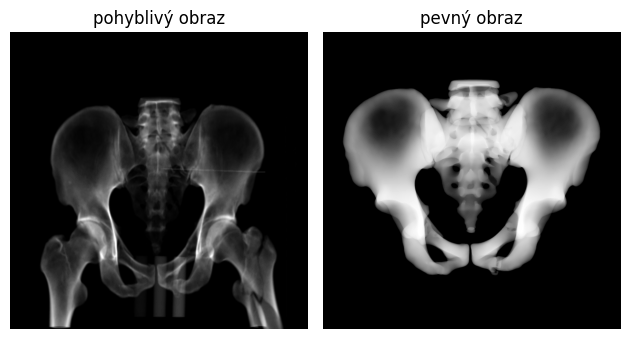

In [7]:
fig2, ax1 = plt.subplots(1, 2)
ax1[0].imshow(sitk.GetArrayViewFromImage(preopImage)[0, ...], cmap="gray")
ax1[1].imshow(sitk.GetArrayViewFromImage(intraopImage)[0, ...], cmap="gray")
ax1[0].set_title("pohyblivý obraz")
ax1[1].set_title("pevný obraz")
ax1[0].axis("off")
ax1[1].axis("off")
fig2.tight_layout()
plt.show()

Fixed image, spacing: (1.0, 1.0, 0.25), size: (1000, 1000, 4),direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0, -0.375)
Moving image, spacing: (1.0, 1.0, 0.25), size: (1000, 1000, 4),direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), origin: (0.0, 0.0, -0.375)


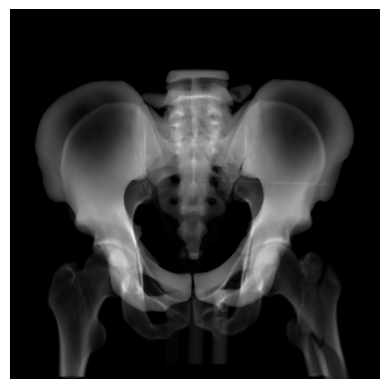

In [8]:
# fixedImage = intraop3dExp
# movingImage = preopImage #[:, :, 0]

fixedImage = sitk.Expand(intraopImage, expandFactors=[1, 1, 4])
movingImage = sitk.Expand(preopImage, expandFactors=[1, 1, 4])

movingImage.SetOrigin(fixedImage.GetOrigin())
movingImage.SetSpacing(fixedImage.GetSpacing())
print(f"Fixed image, spacing: {fixedImage.GetSpacing()}, size: {fixedImage.GetSize()},"
      f"direction: {fixedImage.GetDirection()}, origin: {fixedImage.GetOrigin()}")
print(f"Moving image, spacing: {movingImage.GetSpacing()}, size: {movingImage.GetSize()},"
      f"direction: {movingImage.GetDirection()}, origin: {movingImage.GetOrigin()}")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImage)[0, ...], cmap="gray", alpha=0.5)
plt.axis("off")
plt.show()

In [9]:
initialTransform = sitk.CenteredTransformInitializer(fixedImage, movingImage,
                                                     sitk.AffineTransform(3),
                                                     sitk.CenteredTransformInitializerFilter.MOMENTS)

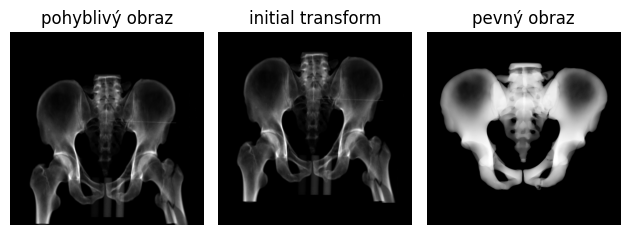

In [10]:
initialImage = sitk.Resample(movingImage, fixedImage, initialTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

fig3, ax2 = plt.subplots(1, 3)
ax2[0].imshow(sitk.GetArrayViewFromImage(movingImage)[0, ...], cmap="gray")
ax2[1].imshow(sitk.GetArrayViewFromImage(initialImage)[0, ...], cmap="gray")
ax2[2].imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
ax2[0].set_title("pohyblivý obraz")
ax2[1].set_title("initial transform")
ax2[2].set_title("pevný obraz")
ax2[0].axis("off")
ax2[1].axis("off")
ax2[2].axis("off")
fig3.tight_layout()
plt.show()

In [11]:
levels = 3
shrinkFactor = [shrink for shrink in range(2, (2 * levels), 2)]
shrinkFactor.insert(0, 1)
smoothFactor = [smooth for smooth in range(0, levels, 1)]

In [12]:
gen_fixed_points = generate_random_pointset(fixedImage, 10)
gen_moving_points = [initialTransform.TransformPoint(p) for p in gen_fixed_points]

#### Inicializace registrace a její parametry

In [13]:
global metric_values, multires_iterations
global reference_mean_values, reference_min_values, reference_max_values

registration = sitk.ImageRegistrationMethod()
registration.SetMetricAsMattesMutualInformation()
registration.SetOptimizerScalesFromPhysicalShift()
registration.SetOptimizerAsGradientDescent(learningRate=1.0,
                                           numberOfIterations=200,
                                           convergenceMinimumValue=1e-5,
                                           convergenceWindowSize=5)
registration.SetInitialTransform(initialTransform, inPlace=False)
registration.SetInterpolator(sitk.sitkLinear)

registration.SetShrinkFactorsPerLevel(shrinkFactors=shrinkFactor[::-1])
registration.SetSmoothingSigmasPerLevel(smoothingSigmas=smoothFactor[::-1])
registration.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration.AddCommand(sitk.sitkStartEvent, metric_and_reference_start_plot)
registration.AddCommand(sitk.sitkEndEvent, metric_and_reference_end_plot)
registration.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration.AddCommand(sitk.sitkIterationEvent, lambda: metric_and_reference_plot_values(registration, gen_fixed_points,
                                                                                          gen_moving_points))
outTransform = registration.Execute(fixedImage, movingImage)
print(f"Optimizer stop condition: {registration.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {registration.GetOptimizerIteration()}")
print(f" Metric value: {registration.GetMetricValue()}")

Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 4.
 Iteration: 4
 Metric value: -0.5088163050808547


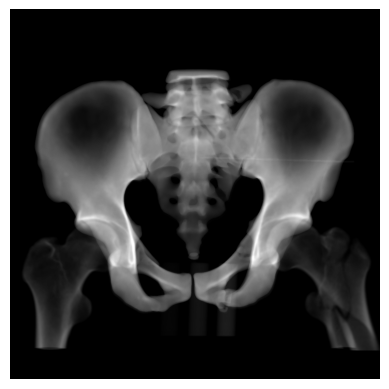

In [14]:
movingImageResampled = sitk.Resample(movingImage, fixedImage, outTransform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())

plt.imshow(sitk.GetArrayViewFromImage(fixedImage)[0, ...], cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(movingImageResampled)[0, ...], cmap="gray", alpha=0.5)
plt.axis("off")
plt.show()

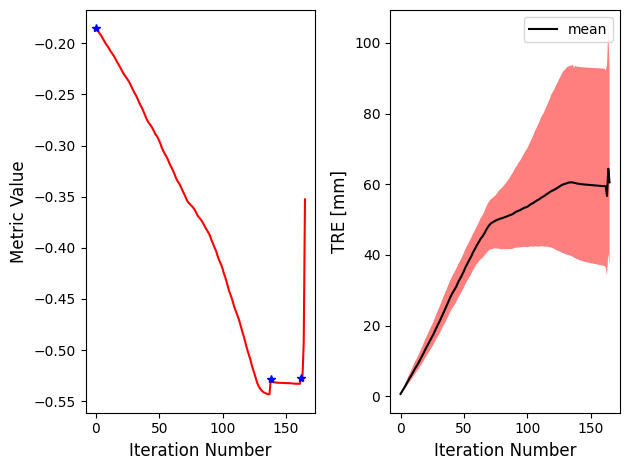

In [15]:
plt.subplot(1, 2, 1)
plt.plot(range(len(metric_values)), metric_values, "r")
plt.plot(multires_iterations,
    [metric_values[index] for index in multires_iterations],
    "b*")
plt.xlabel("Iteration Number", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
# Plot the TRE mean value and the [min-max] range.
plt.subplot(1, 2, 2)
plt.plot(reference_mean_values, color="black", label="mean")
plt.fill_between(
    range(len(reference_mean_values)),
    reference_min_values,
    reference_max_values,
    facecolor="red",
    alpha=0.5,
)
plt.xlabel("Iteration Number", fontsize=12)
plt.ylabel("TRE [mm]", fontsize=12)
plt.legend()

# Adjust the spacing between subplots so that the axis labels don't overlap.
plt.tight_layout()
plt.show()

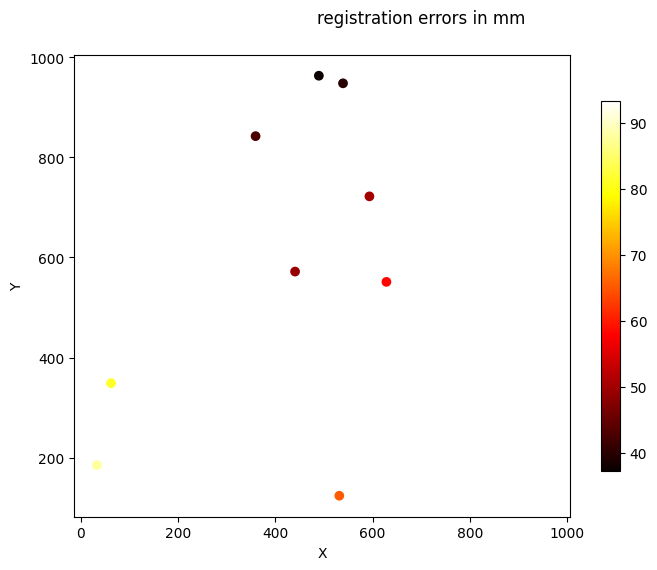

In [18]:
(initial_errors_mean,
 initial_errors_std,
 initial_errors_min,
 initial_errors_max,
 initial_errors_values) = registration_errors(initialTransform, gen_fixed_points, gen_moving_points, 
                                              display_errors=True)

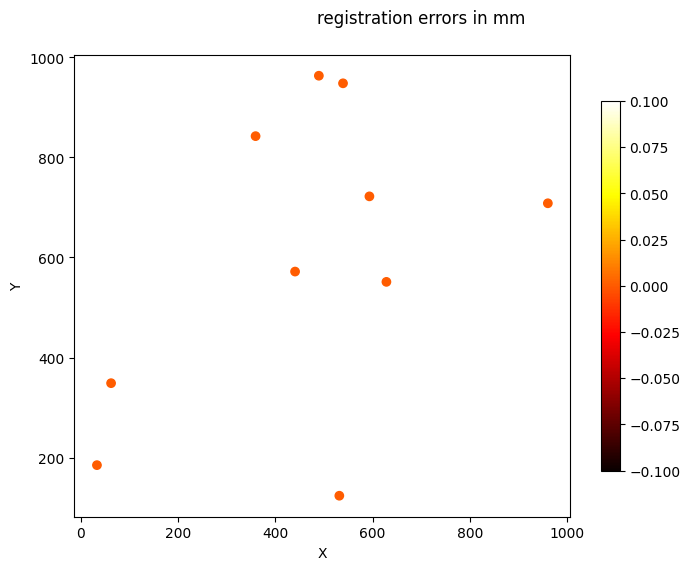

In [19]:
(final_errors_mean,
 final_errors_std,
 final_errors_min,
 final_errors_max,
 final_errors_values) = registration_errors(outTransform, gen_fixed_points, transformedMovingPoints, 
                                            display_errors=True)

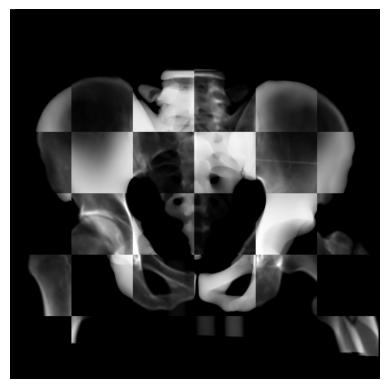

In [42]:
movingImageResampled255 = sitk.Cast(sitk.IntensityWindowing(movingImageResampled, 
                                                            windowMinimum=0., windowMaximum=32767., 
                                                            outputMinimum=0., outputMaximum=255.), 
                                                            sitk.sitkUInt8)
fixedImage255 = sitk.Cast(sitk.IntensityWindowing(sitk.RescaleIntensity(fixedImage, 0, 32767), 
                                                            windowMinimum=0., windowMaximum=32767., 
                                                            outputMinimum=0., outputMaximum=255.), 
                                                            sitk.sitkUInt8)
plt.imshow(sitk.GetArrayViewFromImage(sitk.CheckerBoard(movingImageResampled255, fixedImage255, [6, 6])), cmap="gray")
plt.axis("off")
plt.show()

#### Vykreslení transformace barevnou kompozicí
##### růžová - pevný/fixed/referenční obraz
##### zelená - pohyblivý/moving obraz

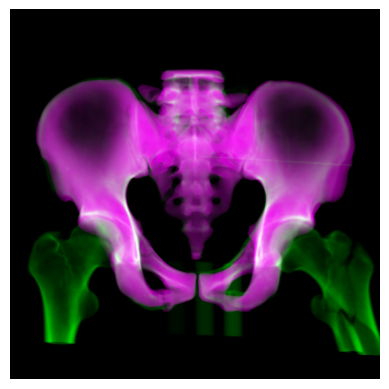

In [53]:
zeros = sitk.Image(movingImageResampled255.GetSize(), movingImageResampled255.GetPixelID())
zeros.CopyInformation(fixedImage255)

composedImage = sitk.Cast(sitk.Compose(fixedImage255, movingImageResampled255, fixedImage255), sitk.sitkVectorUInt8)
plt.imshow(sitk.GetArrayViewFromImage(composedImage))
plt.axis("off")
plt.show()

#### Test obrazová registrace pomocí Elastix knihovnou

In [ ]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)
elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("affine"))
out = elastixImageFilter.Execute()

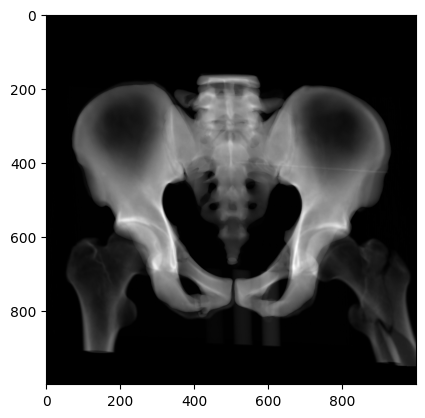

In [77]:
plt.imshow(sitk.GetArrayViewFromImage(out), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray", alpha=0.5)

#### Test detekce hran pro vizualizaci registrace

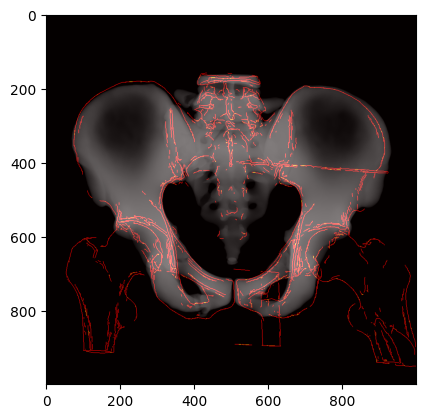

In [96]:
sitkImageEdges = sitk.CannyEdgeDetection(out, lowerThreshold=600, upperThreshold=700)
plt.imshow(sitk.GetArrayViewFromImage(fixedImage), cmap="gray")
plt.imshow(sitk.GetArrayViewFromImage(sitkImageEdges), cmap="hot", alpha=0.5)